In [734]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
import nltk
from nltk import word_tokenize, ngrams
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")
from matplotlib import rcParams

rcParams['figure.figsize'] = 12,8

In [735]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [736]:
train.head()

,Review Text,Review Title,topic
0,"Did nothing for me, didn't help lost even with...",Useless,Shipment and delivery
1,"Did nothing for me, didn't help lost even with...",Useless,Not Effective
2,I have bought these bags and immediately open...,TRASH!!! Do not buy these bags it’s a waist of...,Customer Service
3,Gave me an allergic reaction on my face :(,Do not recommend,Allergic
4,These don't compare to the name brand wipes. F...,Can't tackle big messes,Texture


In [737]:
test_review_text = test['Review Text'].copy()
test_review_title = test['Review Title'].copy()

In [738]:
train.isnull().sum(axis=0)

Review Text     0
Review Title    0
topic           0
dtype: int64

In [739]:
test.duplicated().sum(axis=0)

777

### Data Analysis

In [740]:
df['topic'].value_counts().index

Index(['Bad Taste/Flavor', 'Quality/Contaminated', 'Not Effective', 'Allergic',
       'Packaging', 'Texture', 'Shipment and delivery', 'Customer Service',
       'Color and texture', 'Too big to swallow', 'Ingredients', 'Expiry',
       'Smells Bad', 'Pricing', 'Wrong Product received', 'Too Sweet',
       'Inferior to competitors', 'False Advertisement', 'Didn't Like',
       'Customer Issues', 'Hard to Chew'],
      dtype='object')

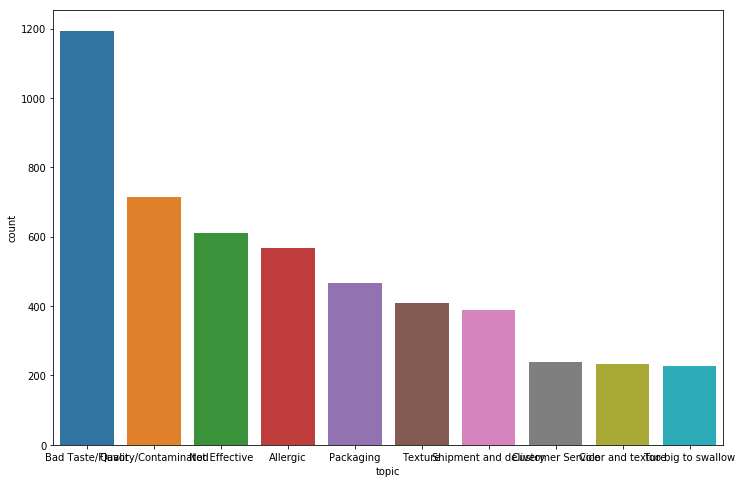

In [760]:
sns.countplot(df['topic'], order = df['topic'].value_counts().head(10).index)

In [742]:
# Append both train and test
df = train.append(test)

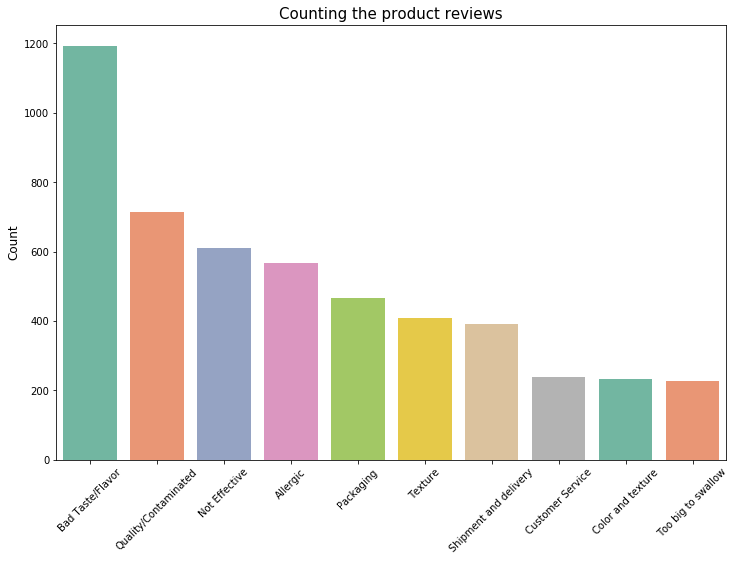

In [743]:
g = sns.countplot('topic', data=df, palette="Set2",order = df['topic'].value_counts().head(10).index)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting the product reviews", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)

plt.show()

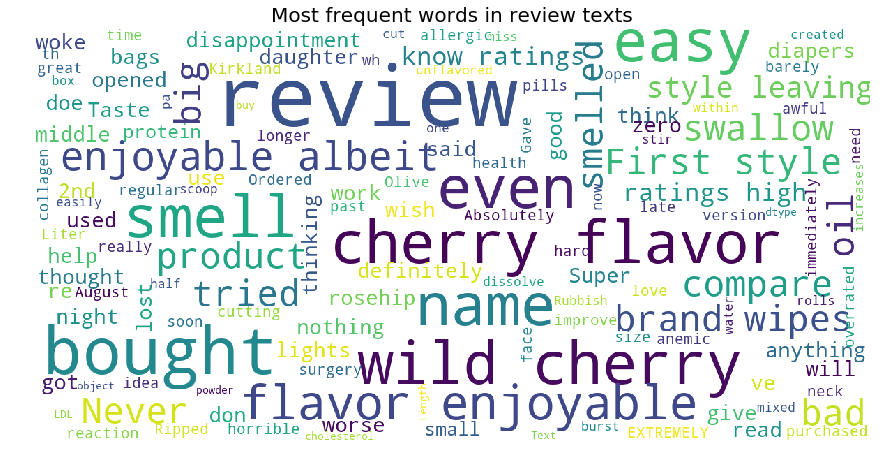

In [744]:
stopwords = set(STOPWORDS) 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1
        
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.title('Most frequent words in review texts',fontsize=20)
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df['Review Text'])

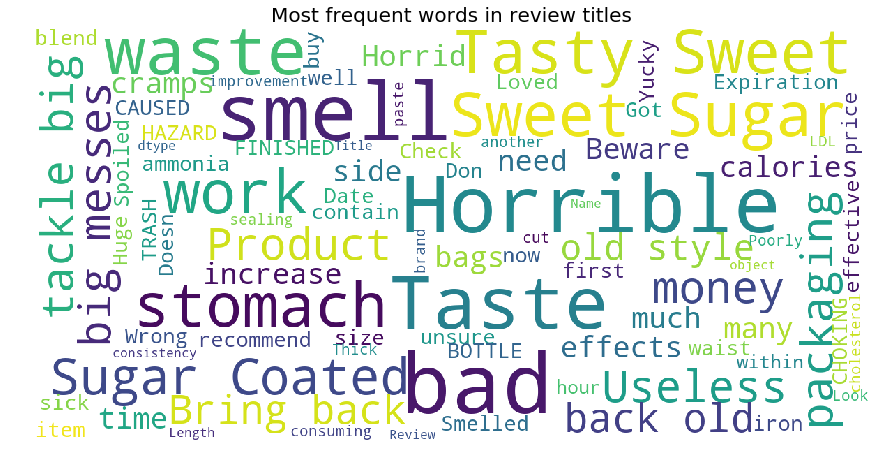

In [745]:
stopwords = set(STOPWORDS) 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1
        
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.title('Most frequent words in review titles',fontsize=20)
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(df['Review Title'])

### Modeling

In [746]:
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge, LSTM, Lambda, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D, GlobalAveragePooling1D,GlobalMaxPool1D
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, concatenate,Concatenate
from keras.layers.merge import concatenate
from keras.layers.core import Dense, Activation, Dropout
import codecs

In [747]:
# with title
train['Review Text'] = train['Review Text'] + ' ' + train['Review Title']
test['Review Text'] = test['Review Text'] + ' ' + test['Review Title']

In [748]:
# function to clean data
import string
import itertools 
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

stop_words = set(stopwords.words('english'))

def cleanData(text, lowercase = False, remove_stops = False, stemming = False, lemmatization = False):
    txt = str(text)
    
    # Replace apostrophes with standard lexicons
    txt = txt.replace("isn't", "is not")
    txt = txt.replace("aren't", "are not")
    txt = txt.replace("ain't", "am not")
    txt = txt.replace("won't", "will not")
    txt = txt.replace("didn't", "did not")
    txt = txt.replace("shan't", "shall not")
    txt = txt.replace("haven't", "have not")
    txt = txt.replace("hadn't", "had not")
    txt = txt.replace("hasn't", "has not")
    txt = txt.replace("don't", "do not")
    txt = txt.replace("wasn't", "was not")
    txt = txt.replace("weren't", "were not")
    txt = txt.replace("doesn't", "does not")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'re", " are")
    txt = txt.replace("'m", " am")
    txt = txt.replace("'d", " would")
    txt = txt.replace("'ll", " will")
    txt = txt.replace("--th", " ")
    
    # More cleaning
    txt = re.sub(r"alot", "a lot", txt)
    txt = re.sub(r"what's", "", txt)
    txt = re.sub(r"What's", "", txt)
    
    
    # Remove urls and emails
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', txt, flags=re.MULTILINE)
    txt = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', txt, flags=re.MULTILINE)
    
    # Replace words like sooooooo with so
    txt = ''.join(''.join(s)[:2] for _, s in itertools.groupby(txt))
    
    # Remove punctuation from text
    txt = ''.join([c for c in text if c not in punctuation])
    
    # Remove all symbols
    txt = re.sub(r'[^A-Za-z\s]',r' ',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stop_words])
        
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])
    
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in txt.split()])

    return txt

In [749]:
# clean reviews
train['Review Text'] = train['Review Text'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True, lemmatization = False))
test['Review Text'] = test['Review Text'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True, lemmatization = False))

### Machine Learning model

In [750]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from catboost import CatBoostClassifier

In [751]:
# XGB Best so far

In [752]:
# clf1 = xgb.XGBClassifier(max_depth=3)
# clf2 = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01)
# clf3 = xgb.XGBClassifier()
# model = VotingClassifier(estimators=[('lr1', clf1), ('lr2', clf2),('lr3', clf3)], voting='soft')

In [764]:
# Minority Classes
cols1 = ['Expiry',
       'Smells Bad', 'Pricing', 'Wrong Product received', 'Too Sweet',
       'Inferior to competitors', 'False Advertisement', 'Didn\'t Like',
       'Customer Issues', 'Hard to Chew']

# Majority Classes
cols2 = ['Bad Taste/Flavor', 'Quality/Contaminated', 'Not Effective', 'Allergic',
       'Packaging', 'Texture', 'Shipment and delivery', 'Customer Service',
       'Color and texture', 'Too big to swallow', 'Ingredients']

### Train two models individually for minority and majority classes

In [765]:
### Linear Model
X = train[train['topic'].isin(cols1)]['Review Text']
y = train[train['topic'].isin(cols1)]['topic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

nb1 = Pipeline([
               ('tfidf', TfidfVectorizer(ngram_range=(1,2), 
               min_df=3, max_df=0.95, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)),
               ('clf', xgb.XGBClassifier()),
              ])
nb1.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb1.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=y))

accuracy 0.8454106280193237
                         precision    recall  f1-score   support

             Smells Bad       1.00      0.75      0.86         4
              Too Sweet       0.70      0.50      0.58        14
                 Expiry       0.93      1.00      0.97        42
             Smells Bad       0.91      0.77      0.83        13
             Smells Bad       1.00      1.00      1.00         2
 Wrong Product received       0.58      0.64      0.61        11
                Pricing       0.81      0.81      0.81        32
    False Advertisement       0.87      0.74      0.80        35
                Pricing       0.82      1.00      0.90        23
 Wrong Product received       0.85      0.94      0.89        31

            avg / total       0.84      0.85      0.84       207



In [722]:
# for cols1
nb1.fit(X, y)
pred1 = nb1.predict_proba(test['Review Text'])

In [755]:
### Linear Model
X = train[train['topic'].isin(cols2)]['Review Text']
y = train[train['topic'].isin(cols2)]['topic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

nb2 = Pipeline([
               ('tfidf', TfidfVectorizer(ngram_range=(1,2), 
               min_df=3, max_df=0.95, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)),
               ('clf', xgb.XGBClassifier()),
              ])
nb2.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb2.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=y))

accuracy 0.5790139064475348
                       precision    recall  f1-score   support

Shipment and delivery       0.56      0.47      0.51       186
        Not Effective       0.58      0.63      0.61       352
     Customer Service       0.26      0.25      0.26        67
             Allergic       0.45      0.27      0.34        70
              Texture       0.43      0.30      0.35        77
 Quality/Contaminated       0.74      0.75      0.75       171
    Color and texture       0.72      0.70      0.71       127
     Bad Taste/Flavor       0.50      0.59      0.54       225
   Too big to swallow       0.81      0.84      0.82       119
 Quality/Contaminated       0.39      0.45      0.42       110
              Texture       0.67      0.62      0.64        78

          avg / total       0.58      0.58      0.58      1582



In [724]:
nb2.fit(X, y)
pred2 = nb2.predict_proba(test['Review Text'])

In [725]:
# Based on the comparison of probabilities assign topics
pred = []
for i in range(len(pred1)):
    m1 = pred1[i].max()
    m2 = pred2[i].max()
    
    if m1>m2:
        pred.append(cols1[pred1[i].argmax()])
    else:
        pred.append(cols2[pred2[i].argmax()])

In [726]:
result = pd.DataFrame()
result['Review Text'] = test_review_text
result['Review Title'] = test_review_title
result['topic'] = pred
result.to_csv("submission_ML.csv",index=False)

### Deep learning Model

In [649]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 500000

In [650]:
tokenizer = Tokenizer(lower=False, filters='',num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(train['Review Text'])

sequences = tokenizer.texts_to_sequences(train['Review Text'])
test_sequences = tokenizer.texts_to_sequences(test['Review Text'])

train_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of train data tensor:', train_data.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

nb_words = (np.max(train_data) + 1)

Shape of train data tensor: (5959, 100)


In [655]:
from keras.layers.recurrent import LSTM, GRU
model = Sequential()
model.add(Embedding(nb_words,150,input_length=MAX_SEQUENCE_LENGTH))
# model.add(SpatialDropout1D(0.2))
# model.add(Bidirectional(GRU(80, return_sequences=True)))
#model.add(GlobalAveragePooling1D())
# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.1))
# model.add(Dense(50, activation="relu"))
# model.add(Dropout(0.1))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(21, activation='sigmoid'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 100, 150)          1440600   
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               142848    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 21)                2709      
Total params: 1,586,157
Trainable params: 1,586,157
Non-trainable params: 0
_________________________________________________________________


In [652]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(train['topic'])

In [653]:
to_categorical(y)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0.], dtype=float32)

In [656]:
model.fit(train_data, to_categorical(y), validation_split=0.2, nb_epoch=5, batch_size=32)

Train on 4767 samples, validate on 1192 samples
Epoch 1/50
4767/4767 [==============================] - 44s 9ms/step - loss: 2.6584 - acc: 0.1970 - val_loss: 2.5772 - val_acc: 0.1946
Epoch 2/50
4767/4767 [==============================] - 42s 9ms/step - loss: 2.3766 - acc: 0.2043 - val_loss: 2.1777 - val_acc: 0.2408
Epoch 3/50
4767/4767 [==============================] - 36s 8ms/step - loss: 1.8978 - acc: 0.3998 - val_loss: 1.8276 - val_acc: 0.4723
Epoch 4/50
4767/4767 [==============================] - 38s 8ms/step - loss: 1.5173 - acc: 0.5312 - val_loss: 1.6892 - val_acc: 0.5050
Epoch 5/50
4767/4767 [==============================] - 35s 7ms/step - loss: 1.2737 - acc: 0.6006 - val_loss: 1.5795 - val_acc: 0.5352
Epoch 6/50
4767/4767 [==============================] - 35s 7ms/step - loss: 1.1088 - acc: 0.6216 - val_loss: 1.5793 - val_acc: 0.5445
Epoch 7/50
4767/4767 [==============================] - 37s 8ms/step - loss: 0.9988 - acc: 0.6535 - val_loss: 1.5178 - val_acc: 0.5487
Epoch 8

In [294]:
pred = model.predict(test_data)

In [295]:
len([x for x in pred.argmax(axis=-1) if x == 1])

717

In [296]:
pred.max(1)

array([0.01414995, 0.01414995, 0.00351582, ..., 0.02954292, 0.06718545,
       0.00182528], dtype=float32)

In [297]:
le.inverse_transform(pred.argmax(axis=-1))

array(['Bad Taste/Flavor', 'Bad Taste/Flavor', 'Not Effective', ...,
       'Bad Taste/Flavor', 'Quality/Contaminated', 'Customer Service'],
      dtype=object)

In [298]:
result = pd.DataFrame()
result['Review Text'] = test_review_text
result['Review Title'] = test_review_title
result['topic'] = le.inverse_transform(pred.argmax(axis=-1))
result.to_csv("submission_DL.csv",index=False)

In [300]:
result.head()

,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
1,I use chia seed in my protein shakes. These ta...,Bad tast,Bad Taste/Flavor
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Quality/Contaminated
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Quality/Contaminated
